# License Plate Detection Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/license-plate-recognition/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [51]:
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/requirements.txt
!pip -q --no-color install -r requirements.txt

File 'requirements.txt' already there; not retrieving.


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [52]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Register License Plate Extraction UDF

In [53]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/ocr_extractor.py"
cursor.execute("DROP UDF LicensePlateExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS LicensePlateExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'license_plate_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

File 'ocr_extractor.py' already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                                 0
0  UDF LicensePlateExtractor successfully dropped
@query_time: 0.02209987910464406
@status: ResponseStatus.SUCCESS
@batch: 
                                                                0
0  UDF LicensePlateExtractor successfully added to the database.
@query_time: 5.75298752496019


# Download Images or Videos for License Plate Recognition

In [54]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_1.png"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/license-plate-recognition/main/test_image_2.png"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car10.jpg"
!wget -nc "https://raw.githubusercontent.com/femioladeji/License-Plate-Recognition-Nigerian-vehicles/master/test_images/car6.jpg"
!wget -nc "https://im.ezgif.com/tmp/ezgif-1-c32008dd2a-jpg/ezgif-frame-001.jpg"
!wget -nc "https://i.ytimg.com/vi/p91epBEfISk/maxresdefault.jpg"

# DOWNLOAD ADDITIONAL IMAGES IF NEEDED AND LOAD THEM HERE

########################################################
###
### IMAGES
###
########################################################

cursor.execute('DROP TABLE IF EXISTS MyImages')
response = cursor.fetch_all()
print(response)

cursor.execute('LOAD IMAGE "test_image_1.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "test_image_2.png" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car10.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "car6.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "ezgif-frame-001.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "maxresdefault.jpg" INTO MyImages;')
response = cursor.fetch_all()
print(response)

cursor.execute("""SELECT LicensePlateExtractor(data)
                FROM MyImages""")
response = cursor.fetch_all()
print(response)

########################################################
###
### VIDEOS
###
########################################################

!wget -nc "https://raw.githubusercontent.com/apoorva-dave/LicensePlateDetector/master/video12.mp4"

# DOWNLOAD ADDITIONAL VIDEOS IF NEEDED AND LOAD THEM HERE

cursor.execute('DROP TABLE IF EXISTS MyVideos')
response2 = cursor.fetch_all()
print(response2)
cursor.execute('LOAD VIDEO "video12.mp4" INTO MyVideos;')
response2 = cursor.fetch_all()
print(response2)
cursor.execute("""SELECT LicensePlateExtractor(data)
                FROM MyVideos
                WHERE id = 10""")
response2 = cursor.fetch_all()
print(response2)


File 'test_image_1.png' already there; not retrieving.

File 'test_image_2.png' already there; not retrieving.

File 'car10.jpg' already there; not retrieving.

File 'car6.jpg' already there; not retrieving.

File 'ezgif-frame-001.jpg' already there; not retrieving.

File 'maxresdefault.jpg' already there; not retrieving.

@status: ResponseStatus.SUCCESS
@batch: 
                                       0
0  Table Successfully dropped: MyImages
@query_time: 0.04169625393114984
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.062016993993893266
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.019084053114056587
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.014059118926525116
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.013

### Annotate Model Output on Image

In [81]:
import cv2
from pprint import pprint
from matplotlib import pyplot as plt
from pathlib import Path

def annotate_image_ocr(detections, input_image_path, frame_id):
    color1=(0, 255, 150)
    color2=(255, 49, 49)
    white=(255, 255, 255)
    thickness=4

    frame = cv2.imread(input_image_path)
    height, width = frame.shape[:2]

    if frame_id == 0:
        frame= cv2.copyMakeBorder(frame, 0, 100, 0, 100, cv2.BORDER_CONSTANT,value=white)

    print(detections)
    plate_id = 0

    df = detections
    df = df[['licenseplateextractor.bboxes', 'licenseplateextractor.labels']][df.index == frame_id]

    x_offset = width * 0.1
    y_offset = height * 0.4

    if df.size:
        dfLst = df.values.tolist()
        for bbox, label in zip(dfLst[plate_id][0], dfLst[plate_id][1]):
            x1, y1, x2, y2 = bbox
            x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])
            # object bbox
            cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 

            # object label
            cv2.putText(frame, label, (int(x1), int(y1 - height * 0.1)), cv2.FONT_HERSHEY_SIMPLEX, (6 * width)/2400, color2, 
                                  int((12 * width)/2400), cv2.LINE_AA) 

            # Show every  frame
            plt.imshow(frame)
            plt.show()

            p = Path(input_image_path)
            output_path = "{0}_{2}{1}".format(p.stem, p.suffix, "output")

            cv2.imwrite(output_path, frame)


  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


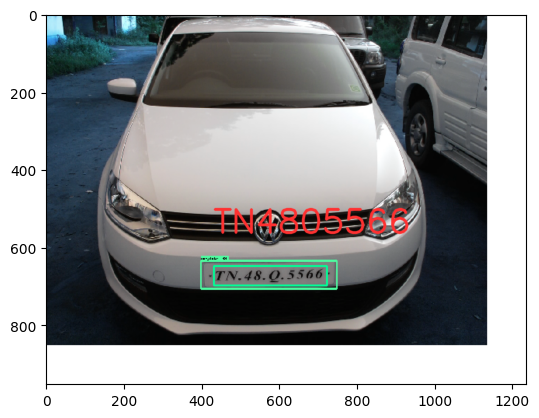

  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


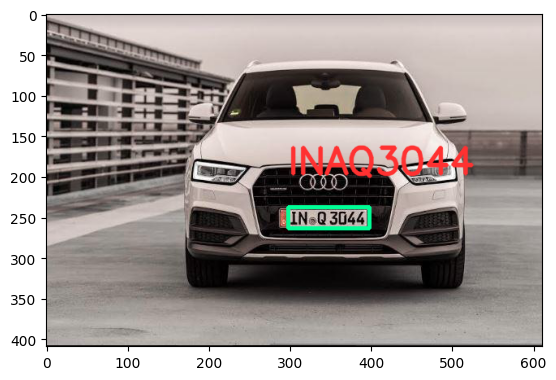

  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


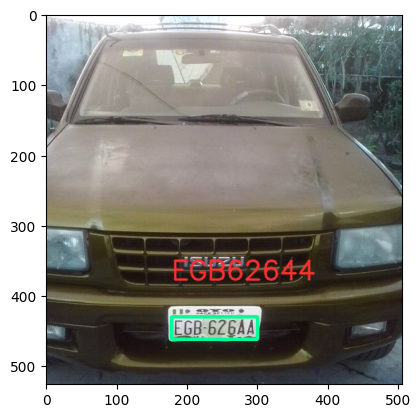

  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


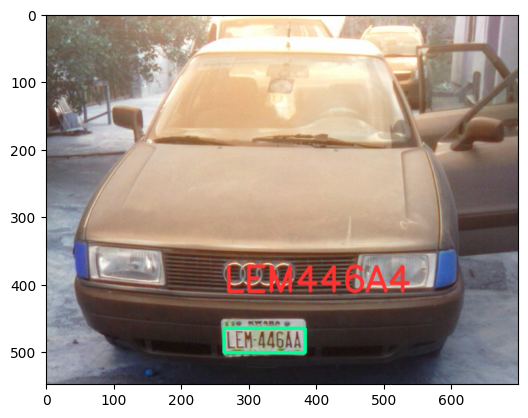

  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


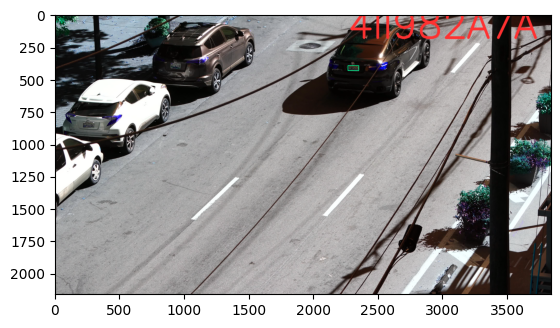

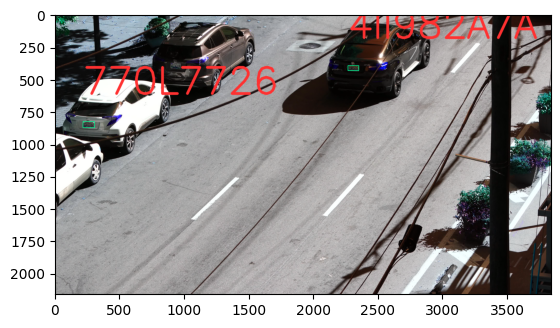

  licenseplateextractor.labels  \
0                  [TN4805566]   
1                   [INAQ3044]   
2                   [EGB62644]   
3                   [LEM446A4]   
4        [4II982A7A, 770L7726]   
5     [LPD7SRV616, IPD8NBZ548]   

                        licenseplateextractor.bboxes  \
0  [[[432, 648], [723, 648], [723, 698], [432, 69...   
1  [[[298, 238], [398, 238], [398, 264], [298, 26...   
2  [[[178, 430], [300, 430], [300, 462], [178, 46...   
3  [[[263, 465], [383, 465], [383, 501], [263, 50...   
4  [[[2263, 398], [2347, 398], [2347, 436], [2263...   
5  [[[236, 372], [344, 372], [344, 396], [236, 39...   

                   licenseplateextractor.scores  
0                           [0.765264012834225]  
1                          [0.5979598335637649]  
2                          [0.8205181373232121]  
3                         [0.37683450003837526]  
4  [0.005999226930693703, 0.041628318390644674]  
5      [0.3380678860228084, 0.8426790601376755]  


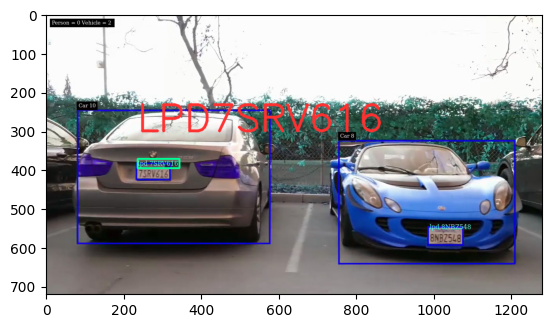

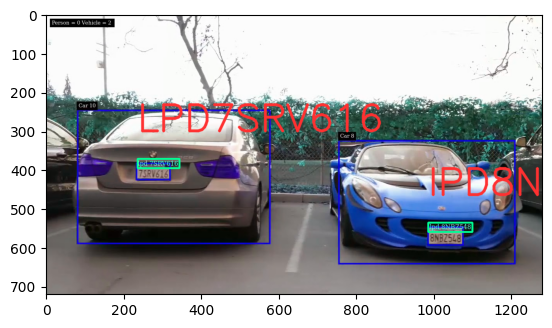

In [82]:
dataframe = response.batch.frames
annotate_image_ocr(dataframe, 'test_image_1.png', frame_id = 0)
annotate_image_ocr(dataframe, 'test_image_2.png', frame_id = 1)
annotate_image_ocr(dataframe, 'car10.jpg', frame_id = 2)
annotate_image_ocr(dataframe, 'car6.jpg', frame_id = 3)
annotate_image_ocr(dataframe, 'ezgif-frame-001.jpg', frame_id = 4)
annotate_image_ocr(dataframe, 'maxresdefault.jpg', frame_id = 5)

## Annotate Model Output on Video

In [57]:
def annotate_video(detections, input_video_path):
    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec

    p = Path(input_video_path)
    output_video_path = "{0}_{2}{1}".format(
        p.stem,  
        p.suffix, 
        "output")
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    # ret = 1 if the video is captured; frame is the image
    ret, frame = vcap.read() 

    x_offset = width * 0.2
    y_offset = height * 0.8

    while ret:

        df = detections
        df = df[['licenseplateextractor.bboxes', 'licenseplateextractor.labels']][df.index == frame_id]

        if df.size:

            dfLst = df.values.tolist()
            for bbox, label in zip(dfLst[frame_id][0], dfLst[frame_id][1]):
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1[0]), int(x1[1]), int(x2[0]), int(x2[1])

                # object bbox
                cv2.rectangle(frame, (x1, y1), (x2, y2), color1, thickness) 

                # object label
                cv2.putText(frame, label, (int(x_offset), int(y_offset)), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness * 4, cv2.LINE_AA) 
                y_offset = y_offset + height * 0.2
        
                video.write(frame)
                
                # Show every fifth frame
                if frame_id % 5 == 0:
                    plt.imshow(frame)
                    plt.show()
        
        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

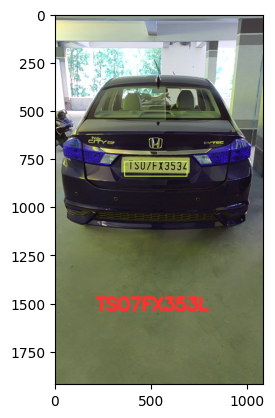

In [58]:
dataframe2 = response2.batch.frames
annotate_video(dataframe2, "video12.mp4")